In [1]:
install.packages("pander")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library("ggplot2")
library("dplyr")
library("scales")
library("pander")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Capítulo 4. Análisis de serie de tiempo

Dado el análisis descriptivo anterior y los resultados vistos en el *Capítulo 2* se proseguirá con un análisis de la cantidad de viajes realizados desde el año $2010$. En particular, nos interesará por una parte conocer el desempeño de los splines cúbicos para interpolar la cantidad de viajes realizados dentro de los datos años comprendidos, pero por otra buscaremos para pronosticar los meses enero, febrero, marzo, abril y mayo del año $2020$, pues se vio en la seccción anterior que hay cambios significativos entre el año anterior, este último punto se realizará en base a la metodología de los modelos $ARIMA$.


La motivación proviene de la situación actual que se vive hoy en día originada por la pandemia por **COVID-19**.

# Introducción

En el presente capítulo se realizará el análisis para la serie de tiempo cantidad de viajes realizados en la Ciudad de México utilizando las bicicletas del programa de gobierno *EcoBici*, en base a *splines cúbicos*.



Los datos se encuentran presentes en cada una de las bases de datos, las cuales pueden obtenerse descargándolas desde la página oficial del programa [Ecobici](https://www.ecobici.cdmx.gob.mx/es/informacion-del-servicio/open-data). Los datos son mensuales y se cuenta con información desde febrero de $2010$ hasta mayo $2020$, por lo que se tiene un total de $124$ observaciones, las cuales representan la cantidad de viajes realizados en el respectivo mes y año.

# Objetivo

Estudiar el desempeño de los splines cúbicos, al interpolar la cantidad de viajes tomando las observaciones (puntos) a nivel o corte:


* Trimestral
* Semestral
* Anual
* Bianual


Así como indicar qué corte obtiene un mejor desempeño en base a la métrica **error cuadrático medio**.

# Metodología

### Lectura y preparación de datos

In [3]:
data <- read.csv("EcoBici.csv", stringsAsFactors = FALSE) ### No se desea que el anio sea un factor, lo queremos como string

In [4]:
head(data)

,Anio,Viajes
,<chr>,<int>
1,2010-02,1057
2,2010-03,21024
3,2010-04,44984
4,2010-05,59814
5,2010-06,64704
6,2010-07,58767


In [5]:
tail(data)

,Anio,Viajes
,<chr>,<int>
119,2019-12,584185
120,2010-01,676908
121,2010-02,686327
122,2010-03,529077
123,2010-04,159780
124,2010-05,153147


Los últimos $5$ años deberían indicar $2020$ en la variable `anio`, a pesar de que indique $2010$.

In [6]:
data$Anio[120:124] <- gsub("2010", "2020", data$Anio[120:124])

Se prefiere trabajar con letras minúsculas para el nombre de las variables, por lo que se cambiará la primera letra del nombre de cada columna a minúscula, además la primer columna `anio` no hace referencia al año únicamente, sino también al mes correspondiente, por lo que hará el cambio del nombre a `fecha`.

In [7]:
colnames(data) <- c("fecha", "viajes")

### Estructura de datos

In [8]:
summary(data)

    fecha               viajes      
 Length:124         Min.   :  1057  
 Class :character   1st Qu.:218704  
 Mode  :character   Median :665850  
                    Mean   :540405  
                    3rd Qu.:745155  
                    Max.   :878358  

In [9]:
str(data)

'data.frame':	124 obs. of  2 variables:
 $ fecha : chr  "2010-02" "2010-03" "2010-04" "2010-05" ...
 $ viajes: int  1057 21024 44984 59814 64704 58767 82329 100164 132294 134082 ...


Nótese que la variable `fecha` aparece como  `chr`, cuando en realidad debería ser un objeto `date` de `R`, a continuación se realizará el cambio correspondiente, para ello se supondrá que todos los meses tienen $28$ días, pues la función `as.Date`, presenta dificultades al tratar de identificar un mes que tiene $28$ días (febrero) al momento de agregarle $30$ días o más.

In [10]:
data$fecha <- as.Date(paste0(data$fecha,"-28"))

Para efectos de este análisis y para facilitar la selección de los distintos cortes (semestral, anual y bianual) se agregará la observación $2010-01-28$ que hace referencia al $28$ de enero de $2010$, cabe mencionar que no se tomará dicha observación para el análisis, es simplemente para faciltar el manejo de las fechas.

In [11]:
new_obs <- data.frame(fecha = as.Date("2010-01-28"), viajes = 0)
new_data <- rbind(new_obs, data)
head(new_data, 12)

,fecha,viajes
,<date>,<dbl>
1,2010-01-28,0
2,2010-02-28,1057
3,2010-03-28,21024
4,2010-04-28,44984
5,2010-05-28,59814
6,2010-06-28,64704
7,2010-07-28,58767
8,2010-08-28,82329
9,2010-09-28,100164


### Splines cúbicos

In [12]:
n <- nrow(new_data)
new_data$time <- 1:nrow(new_data)

In [13]:
trim <- c(2, seq(3, n, 3))
sem <- c(2, seq(6, n, 6))
anual <- c(2 ,seq(12, n, 12))
bianual <- c(2, seq(24, n, 24))

In [14]:
data_trim <- new_data[trim,]
data_sem <- new_data[sem,]
data_anual <- new_data[anual,]
data_bian <- new_data[bianual,]

In [15]:
spl_trim <- spline(data_trim$time, data_trim$viajes)
spl_sem <- spline(data_sem$time, data_sem$viajes)
spl_an <- spline(data_anual$time, data_anual$viajes)
spl_bian <- spline(data_bian$time, data_bian$viajes)

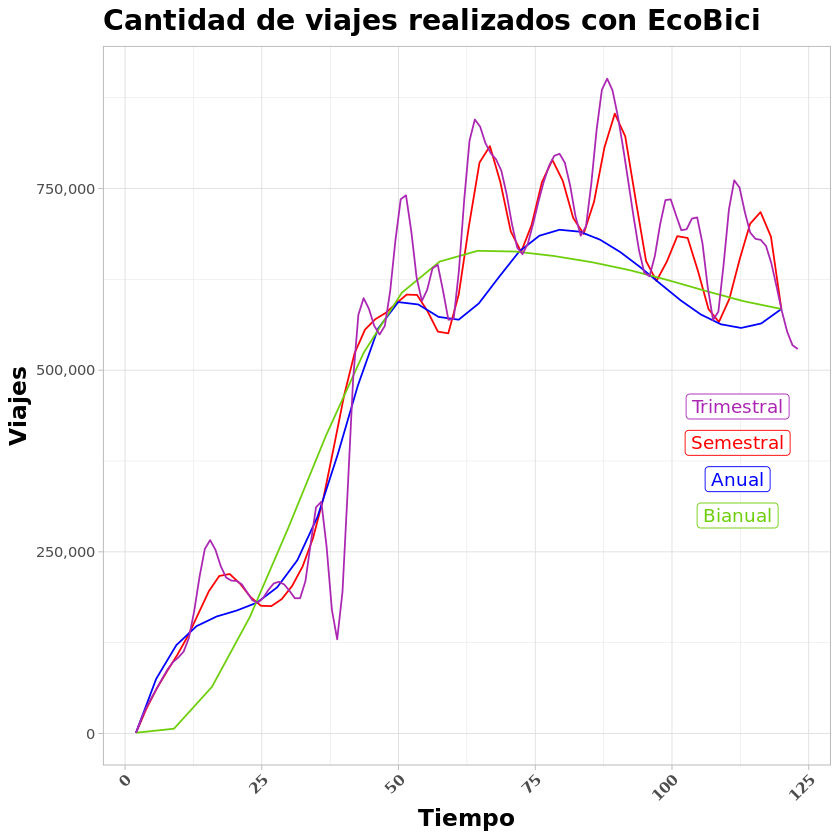

In [16]:
ggplot(data = data.frame(fecha = spl_sem$x, viajes = spl_sem$y), aes(fecha, viajes)) + 
    theme_light() +
    geom_line(color = "red") +
    geom_line(data = data.frame(fecha = spl_an$x, viajes = spl_an$y), color = "blue") +
    geom_line(data = data.frame(fecha = spl_bian$x, viajes = spl_bian$y), color = "#6DCE0A") +
    geom_line(data = data.frame(fecha = spl_trim$x, viajes = spl_trim$y), color = "#AB27B3") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"), 
          plot.title = element_text(size = 17, face = "bold"), 
          axis.title = element_text(size=14, face="bold")) + 
    annotate("label", x = 112, y = 450000, label = "Trimestral", color = "#AB27B3") +
    annotate("label", x = 112, y = 400000, label = "Semestral", color = "red") +
    annotate("label", x = 112, y = 350000, label = "Anual", color = "blue") +
    annotate("label", x = 112, y = 300000, label = "Bianual", color = "#6DCE0A") +
    scale_y_continuous(labels = comma) +
    xlab("Tiempo") + 
    ylab("Viajes") +
    ggtitle("Cantidad de viajes realizados con EcoBici")

In [17]:
spl_trim <- spline(data_trim$time, data_trim$viajes, n = 124)
spl_sem <- spline(data_sem$time, data_sem$viajes, n = 124)
spl_an <- spline(data_anual$time, data_anual$viajes, n = 124)
spl_bian <- spline(data_bian$time, data_bian$viajes, n = 124)

### Evaluación de splines cúbicos

Para el desempeño de cada uno de los splines cúbicos, estos son:



* `spl_sem`: splines cúbicos tomando únicamente los puntos que hacen referencia a periodo semianual (junio $(6)$ y diciembre $(23)$)
* `spl_an`: splines cúbicos tomando únicamente los puntos que hacen referencia a periodos anuales $(2010, 2011, 2012, ..., 2020)$
* `spl_bian`: splines cúbicos tomando únicamente los puntos que hacen referencia a periodos bianuales $(2010, 2012, 2014, ..., 2020)$


Se calculará el error cuadrático medio y el error relativo y se analizará cada uno de ellos por separado.

In [18]:
ecm <- function(x, y){
    ### Calcula el error cuadrático medio
    # Input x (vector): valor real
    # Input y (vector): pronostico o aproximación
    # Output rdo (float): error cuadrático medio entre x, y; o bien regresa string de error en caso de que las dimensiones 
    #                     no sean las mismas
    
    n <- length(x)
    m <- length(y)
    if(n == m){
        rdo <- sum((x-y)^2/x)
    }else{
        rdo <- "Las dimensiones entre los datos debe ser la misma"
    }
    return(rdo)
}

In [19]:
relative_error <- function(x, y){
    ### Calcula el error relativo
    # Input x (float): valor real
    # Input y (float): pronostico o aproximación
    # Output rdo (float): error relativo entre x, y; o bien regresa string de error en caso de que las dimensiones 
    #                     no sean las mismas
    
    rdo <- (abs(x-y)/x)
    return(rdo)
}

In [20]:
rdo_ecm <- data.frame(Spline_cubico = c("Trimestral", "Semestral", "Anual", "Bianual"),
                      Error_cuadratico_medio = c(ecm(data$viajes, spl_trim$y),
                                                 ecm(data$viajes, spl_sem$y),
                                                 ecm(data$viajes, spl_an$y),
                                                 ecm(data$viajes, spl_bian$y)),
                      n = c(nrow(data_trim), nrow(data_sem), nrow(data_anual), nrow(data_bian)))

In [21]:
pander::pander(rdo_ecm)



| Spline_cubico | Error_cuadratico_medio | n  |
|:-------------:|:----------------------:|:--:|
|  Trimestral   |        2724282         | 42 |
|   Semestral   |        4402860         | 21 |
|     Anual     |        4891195         | 11 |
|    Bianual    |        6563978         | 6  |



Obsérvese que el error cuadrático medio, es relativamente grande y aumenta a medida que el periodo temporal es mayor, lo cual es de esperar, debido a que la cantidad de puntos disminuye. A continuación se evaluará el error relativo para una fecha específica, la cual será julio de $2014$.

In [22]:
err_df <- data.frame(Corte = c("Trimestral", "Semestral", "Anual", "Bianual"),
                     Valor_real = rep(data$viajes[54], 4),
                     Interpolacion = c(spl_trim$y[54], spl_sem$y[54], spl_an$y[54],spl_bian$y[54]),
                    Error_relativo = c(relative_error(data$viajes[54], spl_trim$y[54]),
                                       relative_error(data$viajes[54], spl_sem$y[54]),
                                       relative_error(data$viajes[54], spl_an$y[54]),
                                       relative_error(data$viajes[54], spl_bian$y[54])))
pander::pander(err_df)



|   Corte    | Valor_real | Interpolacion | Error_relativo |
|:----------:|:----------:|:-------------:|:--------------:|
| Trimestral |   662974   |    596450     |     0.1003     |
| Semestral  |   662974   |    605605     |    0.08653     |
|   Anual    |   662974   |    593163     |     0.1053     |
|  Bianual   |   662974   |    624343     |    0.05827     |



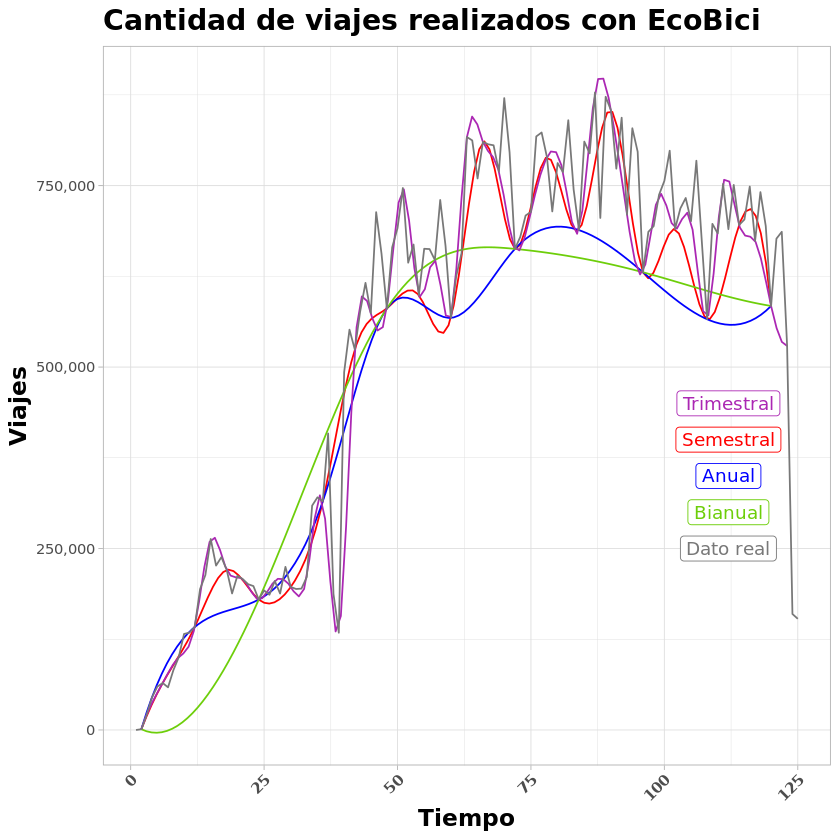

In [23]:
ggplot(data = data.frame(fecha = spl_sem$x, viajes = spl_sem$y), aes(fecha, viajes)) + 
    theme_light() +
    geom_line(color = "red") +
    geom_line(data = data.frame(fecha = spl_an$x, viajes = spl_an$y), color = "blue") +
    geom_line(data = data.frame(fecha = spl_bian$x, viajes = spl_bian$y), color = "#6DCE0A") +
    geom_line(data = data.frame(fecha = spl_trim$x, viajes = spl_trim$y), color = "#AB27B3") +
    geom_line(data = data.frame(fecha = new_data$time, viajes = new_data$viajes), color = "#787878") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"), 
          plot.title = element_text(size = 17, face = "bold"), 
          axis.title = element_text(size=14, face="bold")) + 
    annotate("label", x = 112, y = 450000, label = "Trimestral", color = "#AB27B3") +
    annotate("label", x = 112, y = 400000, label = "Semestral", color = "red") +
    annotate("label", x = 112, y = 350000, label = "Anual", color = "blue") +
    annotate("label", x = 112, y = 300000, label = "Bianual", color = "#6DCE0A") +
    annotate("label", x = 112, y = 250000, label = "Dato real", color = "#787878") +
    scale_y_continuous(labels = comma) +
    xlab("Tiempo") + 
    ylab("Viajes") +
    ggtitle("Cantidad de viajes realizados con EcoBici")

Nótese que todos los modelos de splines cúbicos logran captar la tendencia de la serie de tiempo, esto es: al inicio comienza a crecer y después se estabiliza hasta llegar al año $2020$, en donde comienza a decrecer. Se logra observar la "suavidad" que poseen los splines cúbicos al no dar cambios exageradamente bruscos entre los puntos, sino un comportamiento suave, sin embargo, no logra captar los altibajos que ocurren entre los puntos interpolados.

### Conclusiones

* Los splines cúbicos presentan un buen desempeño, pues ajusta de manera aceptable (a a slimple vista) la serie de puntos interpolados, sin embargo, no es un modelo que presente un excelente desempeño.
* A medida que disminuyen los puntos para obtener los coeficientes del polinomio el error cuadrático medio incrementa casi de manera exponencial.

### Referencias
* [Splines cúbicos en `R`](https://astrostatistics.psu.edu/su07/R/html/stats/html/splinefun.html)